# Wavelet analysis SIE: 
  
## Figure 8 and S5
  
Katie Brennan  
January 2020

In [5]:
import numpy as np
import xarray as xr
#from waveletFunctions import wavelet, wave_signif, wave_bases
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.ticker import StrMethodFormatter, NullFormatter

In [6]:
import sys

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/instrumental_assimilation_experiments/')
import reanalysis_recons_utils as rrutils

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/')
import commonera_utils as ce_utils 

Loading information from datasets.yml
Loading information from grid_def.yml
Loading information from datasets.yml
Loading information from grid_def.yml


In [7]:
def recon_preprocess(var, time, anom_start, anom_end): 
    # Find indices to take anomalies over: 
    anom_ind = np.where((time<anom_end)&(time>=anom_start))
    
    var_2d = np.reshape(var,(var.shape[0],var.shape[1]*var.shape[2]))
    var_anom_2d = var_2d - np.nanmean(np.squeeze(var_2d[anom_ind,:]),axis=0)
    var_anom_mn = np.nanmean(var_anom_2d,axis=1)

    var_97_5 = np.percentile(var_anom_2d,97.5,axis=1)
    var_2_5 = np.percentile(var_anom_2d,2.5,axis=1)
    
    return var_2d, var_anom_2d, var_anom_mn , var_97_5, var_2_5

In [8]:
def plot_cwt(fig, ax, time, period, power, sig95, coi, title, levels, cmap='GnBu'):
    cmap = plt.cm.get_cmap(cmap)
    
    ls = [n/(len(levels)-2) for n in range(len(levels))]

    CS = ax.contourf(time, period, power, levels, 
                     colors = [cmap(n) for n in ls])  #*** or use 'contour'

    #ax.set_xlabel('Time (year)', fontsize=14)
    ax.set_ylabel('Period (years)', fontsize=14)
    ax.set_title(title, fontsize=16, loc='right')
    ax.set_xlim([time.min(),time.max()])

    # 95# significance contour, levels at -99 (fake) and 1 (95# signif)
    ax.contour(time, period, sig95, [-99, 1], colors='k')

    # cone-of-influence, anything "below" is dubious
    ax.plot(time, coi, 'k')
    ax.fill_between(time,coi,y2=period.max(),color='k', alpha=0.5)

    # format y-scale
    ax.set_yscale('log', basey=2, subsy=None) #
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax.yaxis.set_minor_formatter(NullFormatter())
#     ax_x = plt.gca().yaxis
#     ax.set_major_formatter(ticker.ScalarFormatter())
#    ax.ticklabel_format(axis='y', style='plain') #

    ax.set_ylim([period.min(), 500])
    ax.invert_yaxis()
    
    return CS

In [9]:
def get_cwt(data,time,dt,pad,dj,s0,j1,mother,lag1,param=-1):
    n = len(data)
    
    variance = np.std(data, ddof=1) ** 2
    
    # Wavelet transform:
    wave, period, scale, coi = wavelet(data, dt, pad, dj, s0, j1, mother, param=param)
    power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
    global_ws = (np.sum(power, axis=1) / n)  # time-average over all times
    
    # Significance levels:
    signif = wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,lag1=lag1, mother=mother)
    sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand signif --> (J+1)x(N) array
    sig95 = power / sig95  # where ratio > 1, power is significant
    
    return period, power, sig95, coi, time

In [10]:
def calc_lac(fcast, obs):
    """
    Method to calculate the Local Anomaly Correlation (LAC).  Uses numexpr
    for speed over larger datasets.

    Note: If necessary (memory concerns) in the future, the numexpr statements
    can be extended to use pytable arrays.  Would need to provide means to
    function, as summing over the dataset is still very slow it seems.

    Parameters
    ----------
    fcast: ndarray
        Time series of forecast data. M x N where M is the temporal dimension.
    obs: ndarray
        Time series of observations. M x N

    Returns
    -------
    lac: ndarray
        Local anomaly corellations for all locations over the time range.
    """
    # Calculate means of data
    f_mean = fcast.mean(axis=0)
    o_mean = obs.mean(axis=0)
    f_anom = fcast - f_mean
    o_anom = obs - o_mean
    
    # Calculate covariance between time series at each gridpoint
    cov = (f_anom * o_anom).sum(axis=0)

    # Calculate standardization terms
    f_std = (f_anom**2).sum(axis=0)
    o_std = (o_anom**2).sum(axis=0)
#     if is_dask_array(f_std):
#         f_std = da.sqrt(f_std)
#     else:
#         f_std = np.sqrt(f_std)

#     if is_dask_array(o_std):
#         o_std = da.sqrt(o_std)
#     else:
#         o_std = np.sqrt(o_std)
    f_std = np.sqrt(f_std)
    o_std = np.sqrt(o_std)
    
    std = f_std * o_std
    lac = cov / std

    return lac

In [ ]:
def load_ccsm4_lm_regridded():
    ccsm4_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/'
    ccsm4_file = 'ccsm4_sic_sit_tas_20CRv2_850_1850_full.npz'

    ccsm4_lm = np.load(ccsm4_dir+ccsm4_file)

    ccsm4_truth_sic = ccsm4_lm['sic_ccsm4']
    ccsm4_truth_sit = ccsm4_lm['sit_ccsm4']
    ccsm4_truth_tas = ccsm4_lm['tas_ccsm4']
    ccsm4_truth_lat = ccsm4_lm['lat_ccsm4']
    ccsm4_truth_lon = ccsm4_lm['lon_ccsm4']
    
    return ccsm4_truth_tas, ccsm4_truth_sic, ccsm4_truth_sit, ccsm4_truth_lat, ccsm4_truth_lon

In [11]:
[ccsm4_truth_tas, ccsm4_truth_sic, 
 ccsm4_truth_sit,
 ccsm4_truth_lat, ccsm4_truth_lon] = load_ccsm4_lm_regridded()

## Load reconstructed sea ice data: 

In [12]:
output_dir_full = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/ccsm4/'
output_file_full = 'sic_ccsm4_anrecon_0_2000_pages2kv2_inf2_6_loc15000_iter0.pkl'

niter = 10

[sic_lalo_allit_full, tas_lalo_allit_full, sic_ens_var_allit_full, 
 nobs_allit_full, sia_ens_allit_full, sie_ens_allit_full, Ye_assim_allit_full, 
 Ye_assim_coords_allit_full, Xb_inflate_allit_full, recon_years_full, 
 proxy_assim_loc_allit_full] = ce_utils.load_recon_allit(output_dir_full,output_file_full,niter)

In [13]:
output_dir_f770 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/ccsm4/'
output_file_f770 = 'sic_ccsm4_anrecon_fixedprox_1200_1970_fixedprox_inf2_6_loc15000_iter0.pkl'

niter = 1

[sic_lalo_allit_f770, tas_lalo_allit_f770, sic_ens_var_allit_f770, 
 nobs_allit_f770, sia_ens_allit_f770, sie_ens_allit_f770, Ye_assim_allit_f770, 
 Ye_assim_coords_allit_f770, Xb_inflate_allit_f770, recon_years_f770, 
 proxy_assim_loc_allit_f770] = ce_utils.load_recon_allit(output_dir_f770,output_file_f770,niter)

In [14]:
anom_start = 1900
anom_end = 1940

[sie_ens_allit_2d_f770, 
 sie_ens_anom_allit_f770, 
 sie_ensmn_anom_allit_f770, 
 sie_97_5_allit_f770, 
 sie_2_5_allit_f770] = recon_preprocess(sie_ens_allit_f770, np.array(recon_years_f770), anom_start, anom_end)

In [15]:
[sie_ens_allit_2d_full, 
 sie_ens_anom_allit_full, 
 sie_ensmn_anom_allit_full, 
 sie_97_5_allit_full, 
 sie_2_5_allit_full] = recon_preprocess(sie_ens_allit_full, np.array(recon_years_full), anom_start, anom_end)

In [16]:
[ce_full_f770,corr_full_f770,_,_] = rrutils.find_ce_corr(sie_ensmn_anom_allit_f770, 
                                                         sie_ensmn_anom_allit_full,
                                                         np.array(recon_years_full),
                                                         np.array(recon_years_f770),
                                                         1200,1969)

In [17]:
plt.rcParams['figure.dpi']=300

In [ ]:
datavars = {'si_extent_anomalies':(['time','nens'],
                                   sie_ens_anom_allit_f770,
                                 {'units':'10^6 km^2',
                                  'long_name':'reconstructed total Arctic sea ice extent anomalies',
                                  'anomalies_period':'anomalies relative to 1900-1940'}),
            'si_extent_ensemble_mean_anomalies':(['time'],
                                                 sie_ensmn_anom_allit_f770,
                                                 {'units':'10^6 km^2',
                                                  'long_name':'reconstructed total Arctic sea ice extent anomalies',
                                                  'anomalies_period':'anomalies relative to 1900-1940'}),
            'si_extent_97_5_percentiles':(['time'],
                                          sie_97_5_allit_f770,
                                         {'units':'10^6 km^2',
                                          'long_name':'97.5th percentile across all 2000 ensemble members of reconstructed total Arctic sea ice extent anomalies'}),
            'si_extent_2_5_percentiles':(['time'],
                                          sie_2_5_allit_f770,
                                         {'units':'10^6 km^2',
                                          'long_name':'2.5th percentile across all 2000 ensemble members of reconstructed total Arctic sea ice extent anomalies'}),
             'sic_lalo_ensemble_mean':(['time','lat','lon'],
                                        sic_lalo_allit_f770.squeeze(),
                                       {'units':'percent(%)','long_name':'Sea ice concentration'})}

coords = {'time':(['time'],np.array(recon_years_f770),{'units':'year (CE)'}),
          'lat':(['lat'], ccsm4_truth_lat[:,0],{'units':'degrees north'}),
          'lot':(['lot'],ccsm4_truth_lon[0,:],{'units':'degrees east'}),
          'nens':(['nens'],np.arange(0,200,1),{'units':'ensemble member'})}

attrs = {'creation_date':'2021-11-16', 
         'author':'M. Kathleen Brennan', 
         'email':'mkb22@uw.edu',
         'experiment': ('Results from assimilating a fixed set of 101 temperature-sensitive proxie from '+
                        'Pages2kv2 dataset (Emile-Geay et al. 2017) every year and '+
                        'prior ensembles drawn from CCSM4 Last Millennium simulations.')}

ds = xr.Dataset(data_vars=datavars,
               coords=coords,
               attrs=attrs)

savedir = '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/data/'
savename = 'Brennan_etal_2021_CCSM4_fixed_proxy_reconstructions.nc'

ds.to_netcdf(savedir+savename)

## Figure S9: 

In [18]:
from scipy import signal

Wn2 = 1.0/20
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)
sie_full_filt20 = signal.filtfilt(b2,a2,sie_ensmn_anom_allit_full)
sie_f770_filt20 = signal.filtfilt(b2,a2,sie_ensmn_anom_allit_f770)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


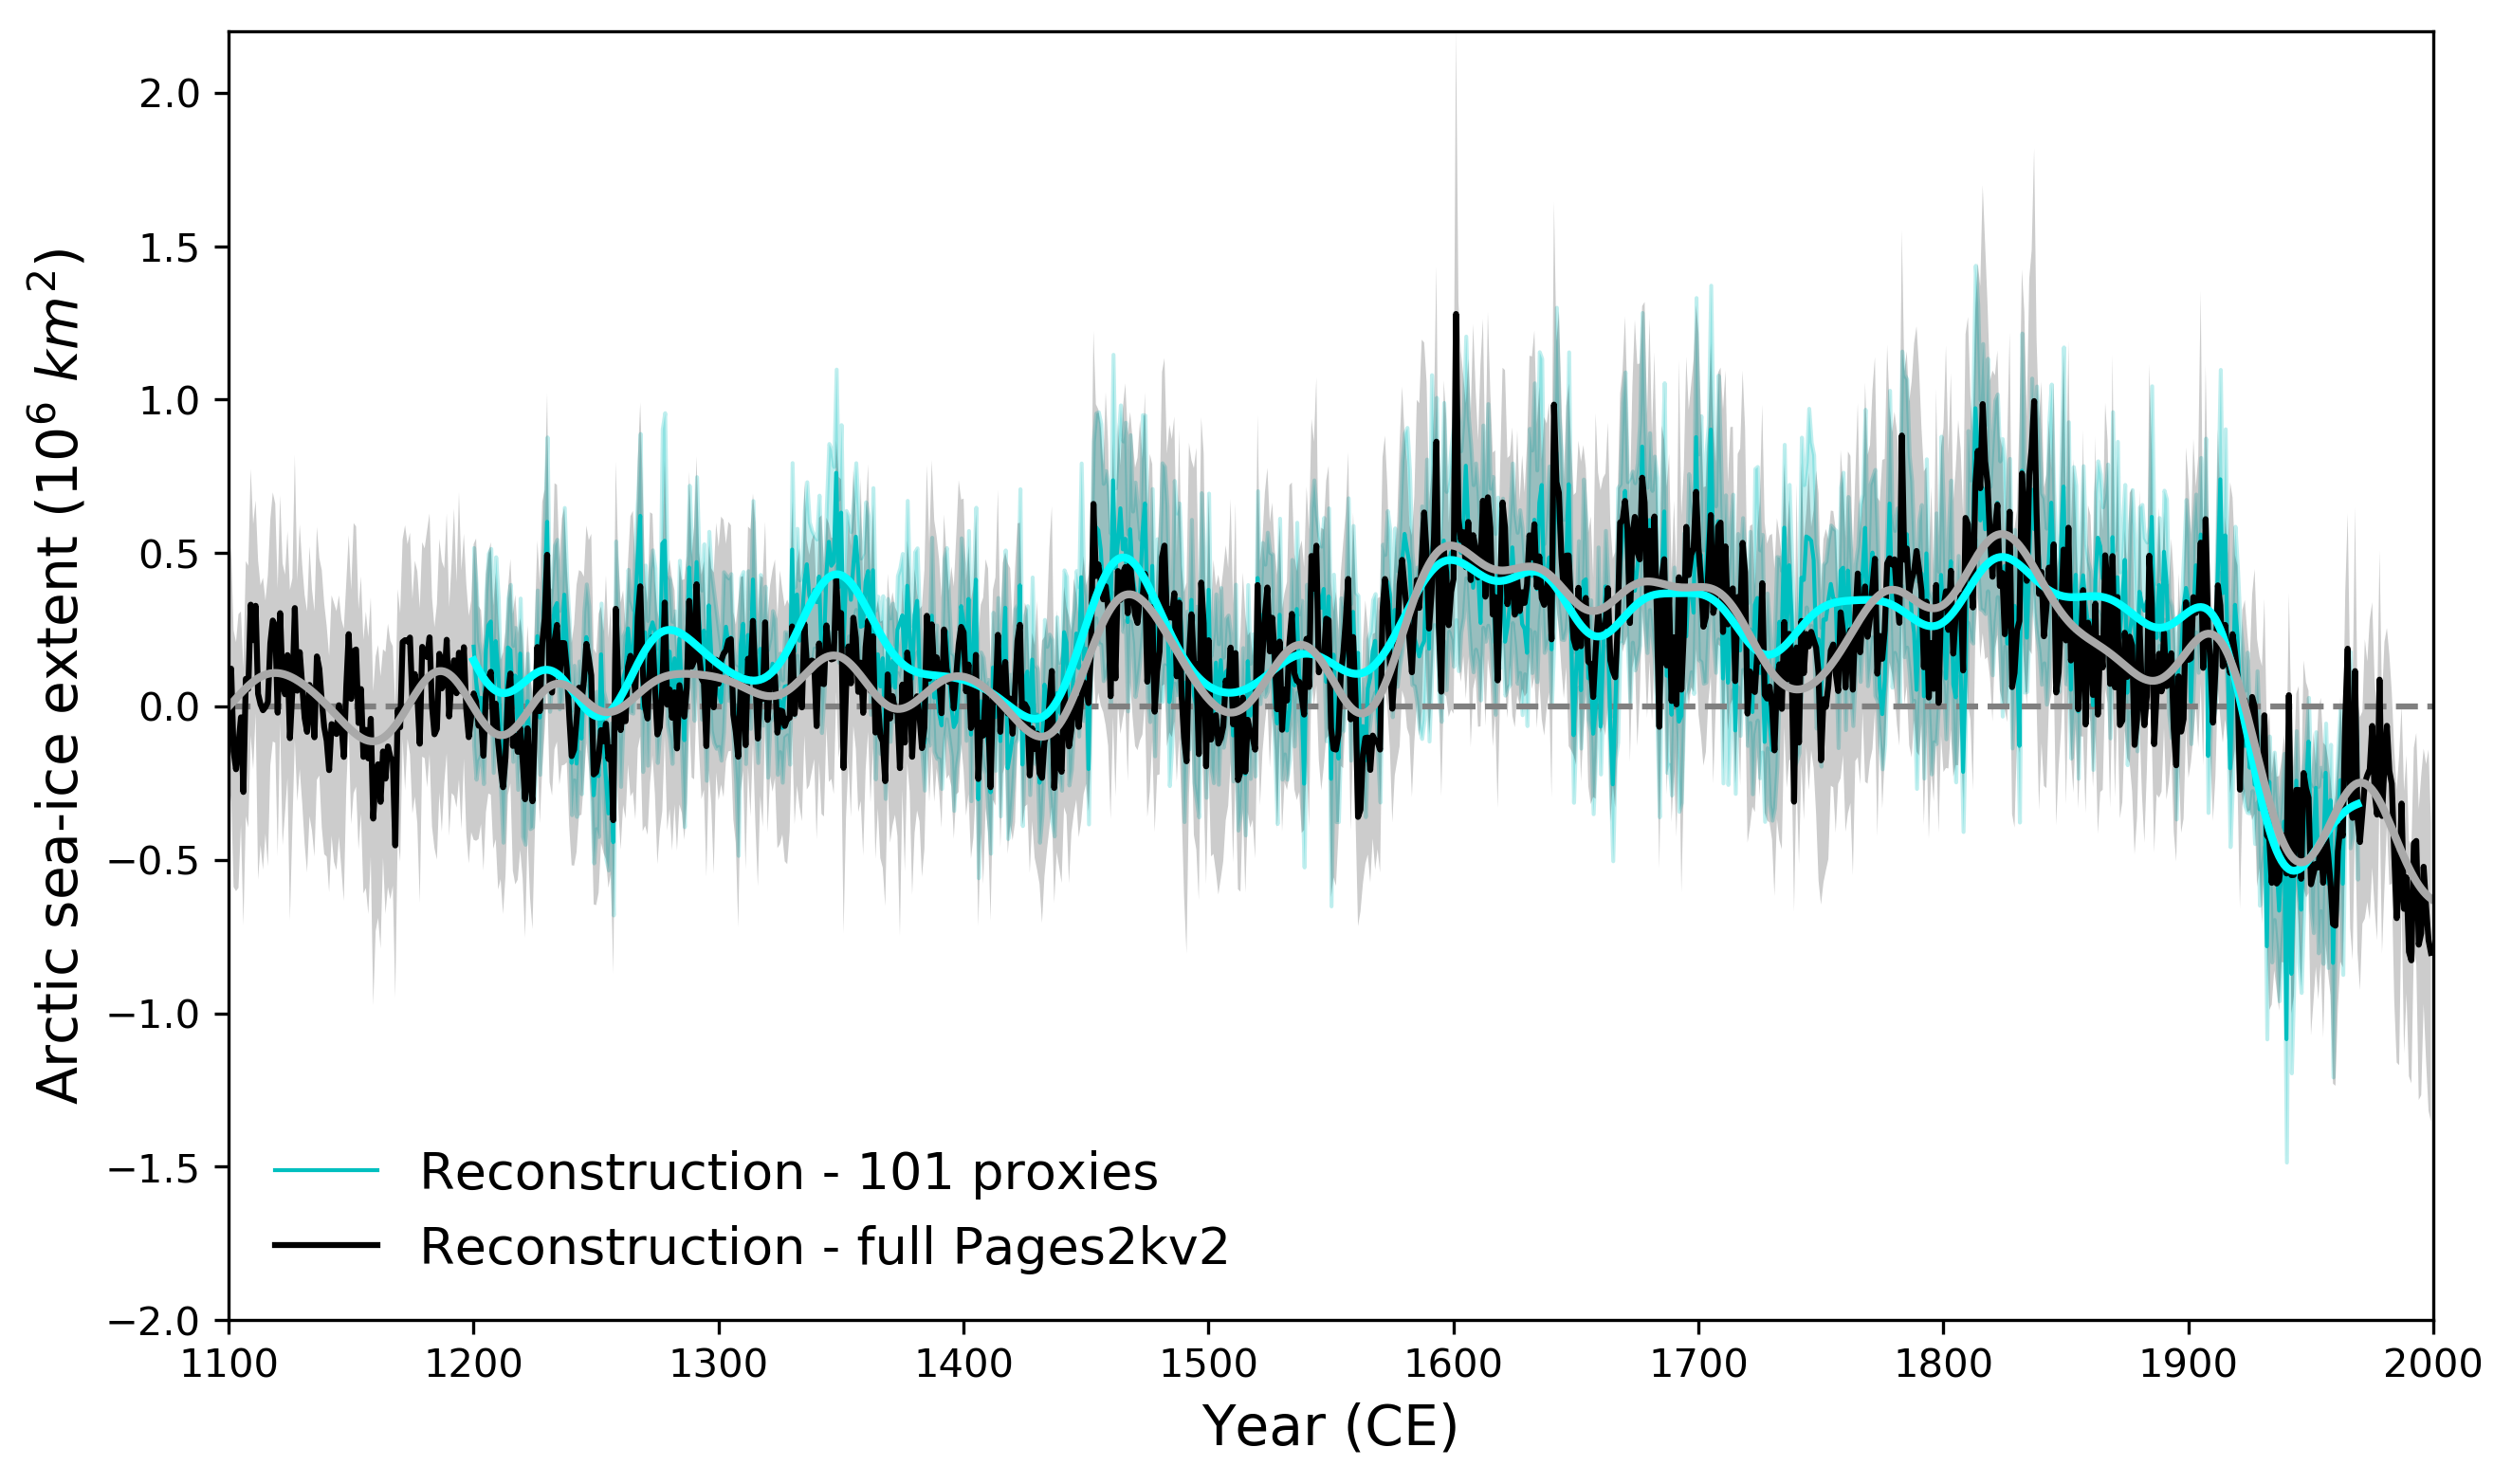

In [19]:
plt.figure(figsize=(10,6))
plt.axhline(0,linestyle='--',color='grey')

plt.fill_between(recon_years_f770,sie_2_5_allit_f770,sie_97_5_allit_f770,
                 color='c',alpha=0.25)
plt.fill_between(recon_years_full,sie_2_5_allit_full,sie_97_5_allit_full,
                 color='k',alpha=0.2, linewidth=0.0)

plt.plot(recon_years_f770,sie_ensmn_anom_allit_f770, label = 'Reconstruction - 101 proxies',
         color='c',linewidth=1.0)
plt.plot(recon_years_full,sie_ensmn_anom_allit_full, label='Reconstruction - full Pages2kv2',
         color='k',linewidth=1.5)

plt.plot(recon_years_f770,sie_f770_filt20,color='cyan',linewidth=2.0)
plt.plot(recon_years_full,sie_full_filt20,color='darkgray',linewidth=2)

plt.ylabel('Arctic sea-ice extent (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)
#plt.title('Total Arctic Sea Ice Extent', fontsize=14)

plt.legend(fontsize=13,loc='lower left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
plt.ylim(-3,4,1)

plt.xlim(1100,2000)
plt.ylim(-2.0,2.2)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Fixed_proxy_full_timeseries_1100_2000.png'
#plt.savefig(savedir+savename)

## Figure 9: 

In [21]:
dt = 1
#time = np.arange(len(sst)) * dt + 1871.0  # construct time array

pad = 1  # pad the time series with zeroes (recommended)
dj =  0.125  # this will do 4 sub-octaves per octave
s0 = 2 * dt  # this says start at a scale of 6 months
j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each
#lag1 = 0.59  # lag-1 autocorrelation for red noise background
#print("lag1 = ", lag1)
mother = 'DOG'
#mother = 'PAUL'
#mother = 'MORLET'
p = 1

In [26]:
lag1_f770 = calc_lac(sie_ensmn_anom_allit_f770[:-1],sie_ensmn_anom_allit_f770[1:])
lag1_full = calc_lac(sie_ensmn_anom_allit_full[:-1],sie_ensmn_anom_allit_full[1:])

lag1_full, lag1_f770

(0.760815356682638, 0.6654263501655744)

In [28]:
[period_f770, power_f770, 
 sig95_f770, coi_f770,
 time_f770] = get_cwt(sie_ensmn_anom_allit_f770,np.array(recon_years_f770),
                      dt,pad,dj,s0,j1,mother,lag1_f770,param=p)

[period_full, power_full, 
 sig95_full, coi_full,
 time_full] = get_cwt(sie_ensmn_anom_allit_full,np.array(recon_years_full),
                      dt,pad,dj,s0,j1,mother,lag1_full,param=p)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


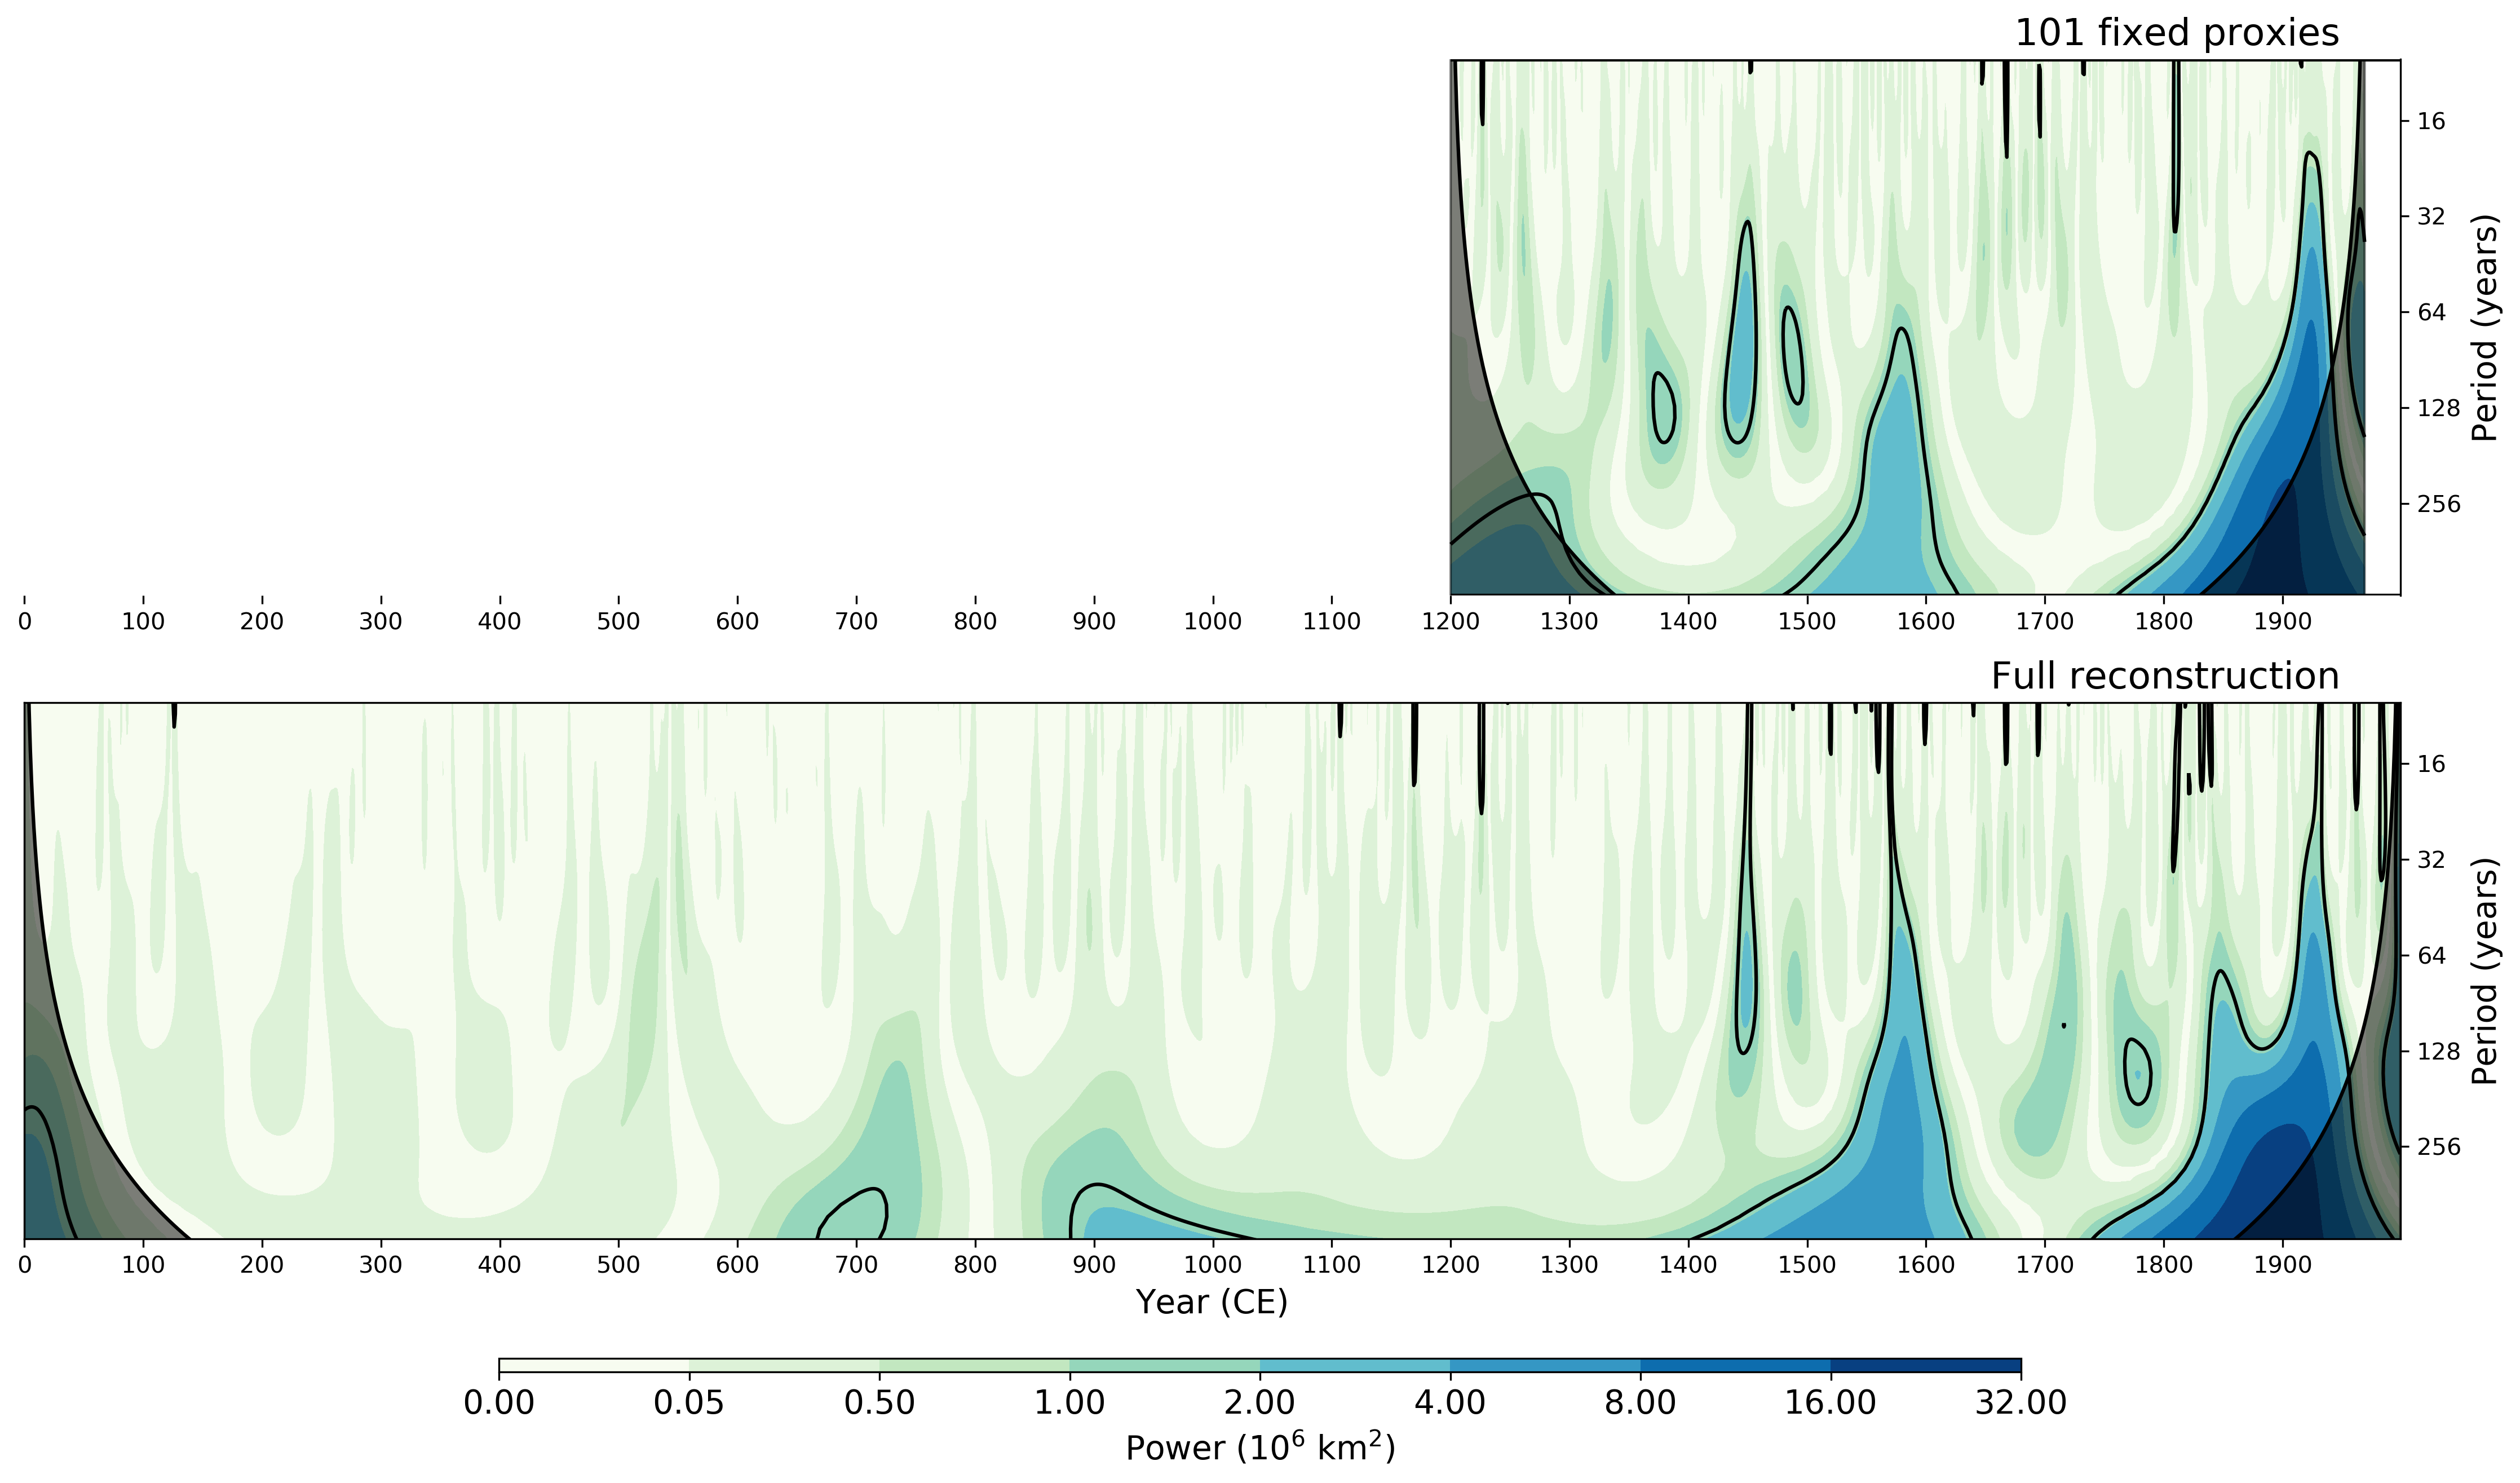

In [29]:
fig, ax = plt.subplots(2,1,figsize=(15, 8), sharex=True)
ax = ax.flatten()
levels = [10-10,0.05,0.5,1,2,4,8,16,32]
title_f400 = '134 fixed proxies     '
title_f770 = '101 fixed proxies     '
title_full = 'Full reconstruction     '

ax[0].set_xticks(np.arange(0,2000,100))
ax[1].set_xticks(np.arange(0,2000,100))

ax[0].xaxis.set_tick_params(which='both', labelbottom=True)

im = plot_cwt(fig, ax[0], time_f770, period_f770, power_f770, sig95_f770, coi_f770, title_f770, 
              levels=levels, cmap='GnBu')
im = plot_cwt(fig, ax[1], time_full, period_full, power_full, sig95_full, coi_full, title_full,
              levels=levels, cmap='GnBu')

ax[1].set_xlabel('Year (CE)', fontsize=14)

#ax[2].set_frame_on(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

ax[0].hlines(10.3,1200,2000,color='k')
ax[0].hlines(500,1200,2000,color='k')

ax[0].yaxis.set_label_position("right")
ax[0].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()

# set up the size and location of the colorbar
position=fig.add_axes([0.2,-0.02,0.6,0.01])
cb = plt.colorbar(im, cax=position, orientation='horizontal') #, fraction=0.05, pad=0.5)
cb.ax.tick_params(labelsize=14)
cb.set_label("Power (10$^6$ km$^2$)", fontsize=14)

plt.xticks(fontsize=14)
plt.subplots_adjust(right=0.7, top=0.9)
plt.tight_layout()

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'cw_analysis_DOG1_f770_full_sharex.png'
#plt.savefig(savedir+savename, bbox_inches='tight')